
# Estimate the covariance-based Granger Causality

This example illustrates how to compute single-trial covariance-based Granger
Causality.


In [1]:
import numpy as np
from itertools import product

from frites.simulations import sim_single_suj_ephy
from frites.conn import (conn_covgc, conn_reshape_directed,
                         conn_reshape_undirected)
from frites import set_mpl_style

import matplotlib.pyplot as plt
import seaborn as sns
set_mpl_style()

## Simulate electrophysiological data

Let's start by simulating MEG / EEG electrophysiological data coming from
a single subject. The output data of this single subject has a shape of
(n_epochs, n_roi, n_times)



In [2]:
modality = 'meeg'
n_roi = 3
n_epochs = 10
n_times = 1000
x, roi, _ = sim_single_suj_ephy(n_epochs=n_epochs, n_times=n_times,
                                modality=modality, n_roi=n_roi, random_state=0)
times = np.linspace(-1, 1, n_times)

## Simulate spatial correlations

Bellow, we are simulating some distant correlations by injecting the
activity of an ROI to another



In [3]:
# instantaneous between 0 and 2 (0.2)
x[:, [2], slice(200, 400)] += x[:, [0], slice(200, 400)]
# directed flow from 2 to 1 (2->1)
x[:, [1], slice(400, 600)] += x[:, [2], slice(400, 600)]
x[:, [2], slice(399, 599)] += x[:, [2], slice(400, 600)]
# directed flow from 0 to 1 (0->1)
x[:, [0], slice(600, 800)] += x[:, [1], slice(600, 800)]
x[:, [0], slice(599, 799)] += x[:, [0], slice(600, 800)]

## Compute the covgc

The covgc is going to be computed per trials, bewteen pairs of ROI and inside
each of the temporal window



In [4]:
t0 = np.arange(100, 900, 10)
lag = 10
dt = 100
gc = conn_covgc(x, dt, lag, t0, times=times, roi=roi, n_jobs=1)
roi_p = gc['roi'].data

Defining links (n_roi=3; directed=False; net=False, nb_min_links=None)
Compute the  covgc (method=gc, normalised=False, n_pairs=3; n_windows=80, lag=10, dt=100, step=1)


  0%|          |  : 0/3 [00:00<?,       ?it/s]

Below we plot the mean time series of both directed and undirected covgc



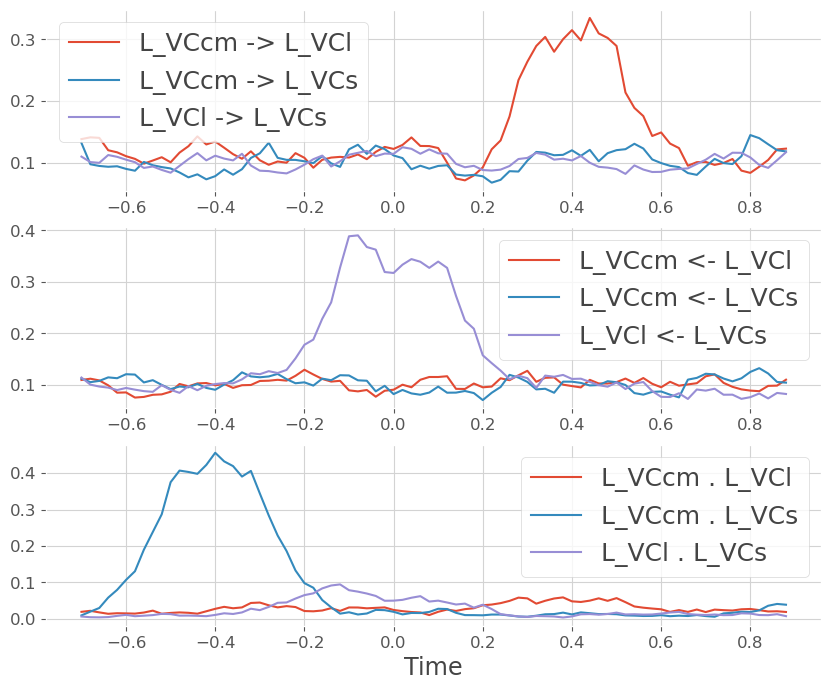

In [5]:
# take the mean across trials
gc = gc.mean('trials')

plt.figure(figsize=(10, 8))
plt.subplot(311)
for r in roi_p:
    plt.plot(gc.times.data, gc.sel(roi=r, direction='x->y').T,
             label=r.replace('-', ' -> '))
plt.legend()
plt.subplot(312)
for r in roi_p:
    plt.plot(gc.times.data, gc.sel(roi=r, direction='y->x').T,
             label=r.replace('-', ' <- '))
plt.legend()
plt.subplot(313)
for r in roi_p:
    plt.plot(gc.times.data, gc.sel(roi=r, direction='x.y').T,
             label=r.replace('-', ' . '))
plt.legend()
plt.xlabel('Time')
plt.show()

Finally, you can also plot the 2D representation of the connectivity arrays



/opt/conda/lib/python3.12/site-packages/frites/conn/conn_utils.py:520: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'roi' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  da[axis] = pd.MultiIndex.from_arrays(
/opt/conda/lib/python3.12/site-packages/frites/conn/conn_utils.py:520: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'roi' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each 

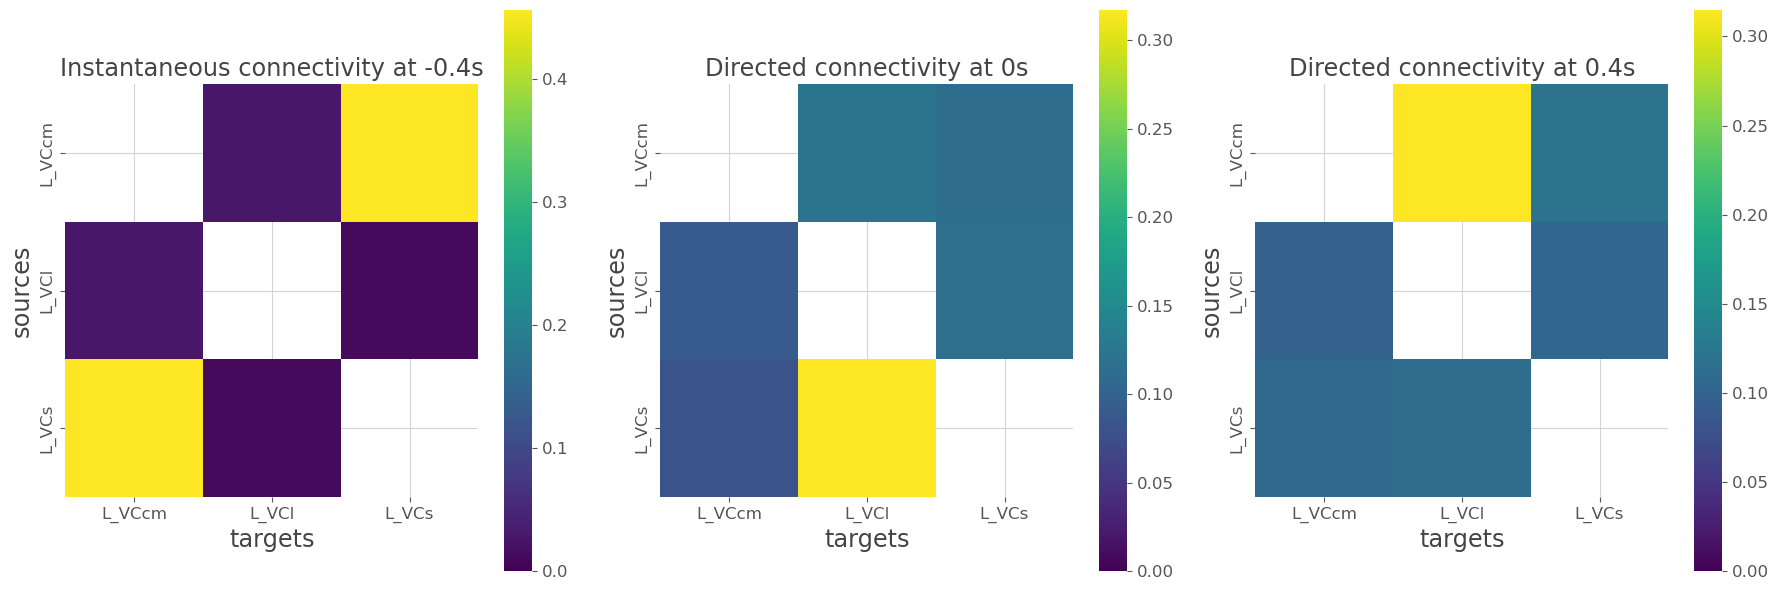

In [6]:
# select instantaneous at -0.4 seconds
gc_inst = gc.copy().sel(times=-.4, method='nearest').sel(direction='x.y')
gc_2d_inst = conn_reshape_undirected(gc_inst, to_dataframe=True)

# select directed connectivity at 0. and 0.4 seconds
gc_0 = gc.copy().sel(times=0., method='nearest')
gc_2d_0 = conn_reshape_directed(gc_0, to_dataframe=True)

gc_04 = gc.copy().sel(times=0.4, method='nearest')
gc_2d_04 = conn_reshape_directed(gc_04, to_dataframe=True)

# plot the 2d connectivity arrays
plt.figure(figsize=(18, 6))

kw = dict(cmap='viridis', vmin=0., square=True)

plt.subplot(131)
sns.heatmap(gc_2d_inst, **kw)
plt.title("Instantaneous connectivity at -0.4s")
plt.subplot(132)
sns.heatmap(gc_2d_0, **kw)
plt.title("Directed connectivity at 0s")
plt.subplot(133)
sns.heatmap(gc_2d_04, **kw)
plt.title("Directed connectivity at 0.4s")
plt.tight_layout()

plt.show()